In [1]:
# # CNN-LSTM 调制识别模型训练与评估 (使用 utils)
#
# 本 Notebook 使用先前 `radioml_preprocessing_cnn_lstm.ipynb` 生成的预处理数据来训练一个 CNN-LSTM 模型。
# 评估和绘图部分将调用外部的 `evaluation_utils.py` 和 `plotting_utils.py` 脚本。

# ## 1. 导入库与环境设置

# --- 基础库 ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import time
import os
import gc # 用于垃圾回收

# --- 绘图和评估工具 ---
# 假设 evaluation_utils.py 和 plotting_utils.py 在同一目录下或 Python 路径中
import matplotlib.pyplot as plt # plt 仍然需要用于显示 utils 生成的图或自定义绘图
import evaluation_utils # 导入评估工具脚本
import plotting_utils   # 导入绘图工具脚本

# --- 其他设置 ---
# 确保 matplotlib 负号显示正常
plt.rcParams['axes.unicode_minus'] = False
# plotting_utils 内部会处理中文字体加载

# --- 设备设置 ---
# 检查是否有可用的 CUDA 设备 (GPU)，否则使用 CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"将使用设备: {device}")

将使用设备: cuda


In [2]:
# ## 2. 配置与常量定义

# --- 路径配置 ---
# 预处理数据的路径 (使用 CNN-LSTM 的功率归一化数据)
PROCESSED_DATA_DIR_DL_NORM = './processed_cnn_lstm_data_powernorm' # 请根据您的实际路径修改

# 模型和结果输出路径
MODEL_OUTPUT_DIR = './models/cnn_lstm_with_utils/'
if not os.path.exists(MODEL_OUTPUT_DIR):
    os.makedirs(MODEL_OUTPUT_DIR)

# --- 模型与文件名配置 ---
MODEL_NAME = "CNN_LSTM" # 用于绘图标题和保存文件名
BEST_MODEL_PATH = os.path.join(MODEL_OUTPUT_DIR, f'{MODEL_NAME}_best_model.pth')

# --- 绘图字体配置 ---
# plotting_utils.py 内部会尝试加载字体，这里定义是为了传递给它
# 确保 NotoSansSC-VariableFont_wght.ttf (或其他字体) 在 'fonts' 子目录中，或系统可用
FONT_FILENAME = "NotoSansSC-VariableFont_wght.ttf" # 与 plotting_utils.py 中使用的字体文件名一致
FONT_SUBDIR = "fonts" # 字体文件所在的子目录 (相对于 plotting_utils.py 或主脚本)

# --- 训练参数 ---
BATCH_SIZE = 128      # 根据 GPU 显存调整
NUM_EPOCHS = 100      # 最大训练轮数 (早停机制可能会提前结束)
LEARNING_RATE = 1e-3  # 初始学习率
WEIGHT_DECAY = 1e-5   # L2 正则化系数 (AdamW 优化器使用)

# --- 其他 ---
# 类别数量 num_classes 将在数据加载后根据 label_mapping 动态确定
# 随机种子设置被注释掉，以允许不同的训练运行结果；如果需要可复现性，请取消注释并设置种子

In [3]:
# ## 3. 加载预处理数据
# 加载由 radioml_preprocessing_cnn_lstm.ipynb 生成的 .npy 文件。

print("--- 3. 加载预处理数据 ---")
# 加载训练、验证、测试集的特征数据 (X) 和整数标签 (y)
try:
    X_train_norm = np.load(os.path.join(PROCESSED_DATA_DIR_DL_NORM, 'X_train_norm.npy'))
    y_train_num = np.load(os.path.join(PROCESSED_DATA_DIR_DL_NORM, 'y_train_num.npy'))

    X_val_norm = np.load(os.path.join(PROCESSED_DATA_DIR_DL_NORM, 'X_val_norm.npy'))
    y_val_num = np.load(os.path.join(PROCESSED_DATA_DIR_DL_NORM, 'y_val_num.npy'))

    X_test_norm = np.load(os.path.join(PROCESSED_DATA_DIR_DL_NORM, 'X_test_norm.npy'))
    y_test_num = np.load(os.path.join(PROCESSED_DATA_DIR_DL_NORM, 'y_test_num.npy'))
    snr_test = np.load(os.path.join(PROCESSED_DATA_DIR_DL_NORM, 'snr_test.npy')) # 用于按 SNR 评估

    # 加载标签映射关系 (整数 -> 原始字符串标签)
    label_mapping_path = os.path.join(PROCESSED_DATA_DIR_DL_NORM, 'label_mapping.npy')
    label_map = np.load(label_mapping_path, allow_pickle=True).item() # .item() 将 0-d array 转为 dict
    print(f"原始标签映射 (label_map): {label_map}")

except FileNotFoundError as e:
    print(f"错误：加载预处理数据文件失败。请确保 '{PROCESSED_DATA_DIR_DL_NORM}' 目录存在且包含所有 .npy 文件。")
    print(f"具体错误: {e}")
    # 可能需要在此处停止执行
    raise e

# --- 动态确定类别数量和名称列表 (确保与标签数据一致) ---
possible_num_classes = []
if 'y_train_num' in locals() and y_train_num.size > 0:
    possible_num_classes.append(int(y_train_num.max()) + 1)
if 'y_val_num' in locals() and y_val_num.size > 0:
    possible_num_classes.append(int(y_val_num.max()) + 1)
if 'y_test_num' in locals() and y_test_num.size > 0:
    possible_num_classes.append(int(y_test_num.max()) + 1)

if not possible_num_classes: # 如果所有 y 数组都为空或未加载
    if 'label_map' in locals() and label_map:
        num_classes = len(label_map)
        print(f"警告：标签数组为空，num_classes 基于 label_map 大小：{num_classes}")
    else:
        print("错误：标签数组和 label_map 均为空或未加载，无法确定 num_classes。")
        num_classes = 0 # 或者抛出错误
else:
    # 使用标签数据中的最大值来确定类别数量，这更可靠
    num_classes = max(possible_num_classes)
    if 'label_map' in locals() and len(label_map) != num_classes:
        print(f"警告: label_map 的大小 ({len(label_map)}) 与从标签数据推断的类别数 ({num_classes}) 不匹配。将以标签数据为准。")

# 创建 target_names 列表 (用于评估报告和绘图标签)，确保顺序与整数标签 0, 1, ... 对应
target_names = [""] * num_classes # 初始化一个正确长度的列表
all_keys_found = True
all_values_are_strings = True

if 'label_map' in locals():
    for i in range(num_classes):
        if i in label_map:
            class_name = label_map[i]
            if isinstance(class_name, str):
                target_names[i] = class_name
            else:
                print(f"错误: label_map 中键 {i} 对应的值 '{class_name}' 不是字符串。将使用临时名称。")
                target_names[i] = f"Class_{i}" # 提供一个临时的字符串名称
                all_values_are_strings = False
        else:
            print(f"错误: 数字标签 {i} 在 label_map 中未找到! 请检查您的 label_mapping.npy 文件。将使用占位符。")
            target_names[i] = f"UnknownClass_{i}" # 使用占位符
            all_keys_found = False
else:
     print("错误: label_map 未加载，无法创建 target_names。")
     target_names = [f"Class_{i}" for i in range(num_classes)] # 如果label_map不存在，生成临时名称

if not all_keys_found:
    print("警告: 并非所有期望的数字标签都在 label_map 中找到。target_names 可能不完整或不正确。")
if not all_values_are_strings:
    print("警告: label_map 中的部分值不是字符串。target_names 中可能包含临时生成的名称。")
# --- 动态确定结束 ---

# 打印加载的数据形状和信息
print(f"\nX_train_norm shape: {X_train_norm.shape if 'X_train_norm' in locals() else '未加载'}, y_train_num shape: {y_train_num.shape if 'y_train_num' in locals() else '未加载'}")
print(f"X_val_norm shape: {X_val_norm.shape if 'X_val_norm' in locals() else '未加载'}, y_val_num shape: {y_val_num.shape if 'y_val_num' in locals() else '未加载'}")
print(f"X_test_norm shape: {X_test_norm.shape if 'X_test_norm' in locals() else '未加载'}, y_test_num shape: {y_test_num.shape if 'y_test_num' in locals() else '未加载'}, snr_test shape: {snr_test.shape if 'snr_test' in locals() else '未加载'}")
print(f"标签映射: {label_map if 'label_map' in locals() else '未加载'}")
print(f"类别名称 (target_names): {target_names}")
print(f"类别数量: {num_classes}")

gc.collect()

--- 3. 加载预处理数据 ---
原始标签映射 (label_map): {0: '8PSK', 1: 'AM-DSB', 2: 'AM-SSB', 3: 'BPSK', 4: 'CPFSK', 5: 'GFSK', 6: 'PAM4', 7: 'QAM16', 8: 'QAM64', 9: 'QPSK', 10: 'WBFM'}

X_train_norm shape: (132000, 128, 2), y_train_num shape: (132000,)
X_val_norm shape: (44000, 128, 2), y_val_num shape: (44000,)
X_test_norm shape: (44000, 128, 2), y_test_num shape: (44000,), snr_test shape: (44000,)
标签映射: {0: '8PSK', 1: 'AM-DSB', 2: 'AM-SSB', 3: 'BPSK', 4: 'CPFSK', 5: 'GFSK', 6: 'PAM4', 7: 'QAM16', 8: 'QAM64', 9: 'QPSK', 10: 'WBFM'}
类别名称 (target_names): ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
类别数量: 11


88

In [4]:
# ## 4. 定义 PyTorch Dataset 和 DataLoader
# 创建自定义 Dataset 类以加载数据并应用数据增强。
# 使用 DataLoader 高效地加载批处理数据。

import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import random # 用于数据增强中的随机选择

# --- 数据增强函数 ---
def add_gaussian_noise(signal_iq, snr_db_range=(10, 30)):
    """向 I/Q 信号添加高斯白噪声。
    Args:
        signal_iq (np.ndarray): 输入信号，形状为 (2, sequence_length)。假定信号功率已归一化。
        snr_db_range (tuple): 添加噪声的 SNR 范围 (dB)。
    Returns:
        np.ndarray: 添加噪声后的信号，形状为 (2, sequence_length)。
    """
    # 假设输入信号的平均功率接近 1 (因为之前做了功率归一化)
    signal_power = 1.0
    snr_db = random.uniform(snr_db_range[0], snr_db_range[1])
    snr_linear = 10**(snr_db / 10.0)
    noise_power = signal_power / snr_linear
    # 噪声功率分配给实部和虚部，每个的方差是 noise_power / 2
    noise_std_dev = np.sqrt(noise_power / 2)
    noise_real = noise_std_dev * np.random.randn(signal_iq.shape[1])
    noise_imag = noise_std_dev * np.random.randn(signal_iq.shape[1])
    # 直接添加到 I, Q 分量
    noisy_signal_iq = signal_iq.copy()
    noisy_signal_iq[0, :] += noise_real
    noisy_signal_iq[1, :] += noise_imag
    return noisy_signal_iq.astype(np.float32)

def random_phase_shift(signal_iq):
    """对 I/Q 信号应用随机相位偏移。
    Args:
        signal_iq (np.ndarray): 输入信号，形状为 (2, sequence_length)。
    Returns:
        np.ndarray: 相位偏移后的信号，形状为 (2, sequence_length)。
    """
    signal_complex = signal_iq[0, :] + 1j * signal_iq[1, :]
    random_phase = np.random.uniform(-np.pi, np.pi)
    shifted_signal_complex = signal_complex * np.exp(1j * random_phase)
    shifted_signal_iq = np.vstack((shifted_signal_complex.real, shifted_signal_complex.imag))
    return shifted_signal_iq.astype(np.float32)

def random_time_shift(signal_iq, max_shift=10):
    """对 I/Q 信号应用随机时间循环平移 (抖动)。
    Args:
        signal_iq (np.ndarray): 输入信号，形状为 (2, sequence_length)。
        max_shift (int): 最大平移样本数。
    Returns:
        np.ndarray: 时间平移后的信号，形状为 (2, sequence_length)。
    """
    sequence_length = signal_iq.shape[1]
    # 随机选择平移量，范围 [-max_shift, max_shift]
    shift_amount = random.randint(-max_shift, max_shift)
    # 对 I 和 Q 通道应用相同的循环平移
    shifted_signal_iq = np.roll(signal_iq, shift=shift_amount, axis=1)
    return shifted_signal_iq.astype(np.float32)

# --- 自定义 PyTorch Dataset 类 (含增强) ---
class SignalDataset(Dataset):
    """用于加载信号数据的 PyTorch Dataset，支持数据增强。"""
    def __init__(self, X, y, augment=False, max_time_shift=10, noise_snr_range=(10, 30)):
        # 输入 X 期望形状 (N, L, C)，需要转置为 PyTorch Conv1d 期望的 (N, C, L)
        # C=2 (I/Q), L=128
        if X.shape[2] == 2 and X.shape[1] == 128:
             # (N, 128, 2) -> (N, 2, 128)
            self.X_data = X.transpose(0, 2, 1).astype(np.float32)
        else:
            print(f"警告: 输入 X 的形状 {X.shape} 不符合预期 (N, 128, 2)，可能导致错误。")
            self.X_data = X.astype(np.float32) # 尝试继续，但可能需要调整模型输入层

        self.y_data = y.astype(np.int64) # 标签应为 Long 类型以用于 CrossEntropyLoss
        self.augment = augment
        self.max_time_shift = max_time_shift
        self.noise_snr_range = noise_snr_range # 存储噪声 SNR 范围

    def __len__(self):
        return len(self.X_data)

    def __getitem__(self, idx):
        signal = self.X_data[idx].copy() # 获取原始信号 (C, L)，例如 (2, 128)
        label = self.y_data[idx]

        if self.augment:
            # --- 应用随机增强 ---
            # 50% 概率添加高斯噪声 (使用指定的 SNR 范围)
            if random.random() < 0.5:
                signal = add_gaussian_noise(signal, snr_db_range=self.noise_snr_range)

            # 50% 概率应用随机相位偏移
            if random.random() < 0.5:
                signal = random_phase_shift(signal)

            # 50% 概率应用随机时间抖动
            if random.random() < 0.5:
                 signal = random_time_shift(signal, max_shift=self.max_time_shift)

        # 将 NumPy 数组转换为 PyTorch 张量
        signal_tensor = torch.tensor(signal, dtype=torch.float32) # (C, L)
        label_tensor = torch.tensor(label, dtype=torch.long) # (scalar)

        return signal_tensor, label_tensor

# --- 创建 DataLoader 实例 ---
print("创建 Dataset 和 DataLoader (训练集启用增强)...")
# 确保 X_train_norm 等变量存在
try:
    if 'X_train_norm' not in globals() or 'y_train_num' not in globals() or \
       'X_val_norm' not in globals() or 'y_val_num' not in globals() or \
       'X_test_norm' not in globals() or 'y_test_num' not in globals():
           raise NameError("数据数组 (X_*, y_*) 未加载或已删除")

    # 数据增强参数
    MAX_SHIFT_AUG = 10      # 时间抖动的最大偏移量
    NOISE_SNR_RANGE = (10, 30) # 添加噪声的 SNR dB 范围

    # 创建 Dataset 实例
    train_dataset = SignalDataset(X_train_norm, y_train_num, augment=True, max_time_shift=MAX_SHIFT_AUG, noise_snr_range=NOISE_SNR_RANGE)
    val_dataset = SignalDataset(X_val_norm, y_val_num, augment=False) # 验证集不应使用增强
    test_dataset = SignalDataset(X_test_norm, y_test_num, augment=False)  # 测试集不应使用增强

    # DataLoader 参数
    num_workers = 0 # Windows 下通常设为 0，Linux/macOS 可根据 CPU 核数调整
    pin_memory_flag = True if device.type == 'cuda' else False # 如果使用 GPU，开启 pin_memory 可能加速数据传输

    # 确保 BATCH_SIZE 变量已定义
    if 'BATCH_SIZE' not in globals(): BATCH_SIZE = 128 # 使用默认值或从配置获取

    # 创建 DataLoader 实例
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=pin_memory_flag, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=pin_memory_flag, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=pin_memory_flag, num_workers=num_workers)

    print(f"Train DataLoader: {len(train_loader)} batches")
    print(f"Validation DataLoader: {len(val_loader)} batches")
    print(f"Test DataLoader: {len(test_loader)} batches")

except NameError as e:
    print(f"错误: 缺少必要的数据变量来创建 Dataset/DataLoader。请确保数据已加载。错误信息: {e}")
    # 可能需要停止执行
    raise e
except Exception as e:
    print(f"创建 Dataset/DataLoader 时发生意外错误: {e}")
    raise e

# --- 清理内存 (可选) ---
# 如果内存非常紧张，可以在此处删除大的 NumPy 数组
# try:
#     del X_train_norm, y_train_num, X_val_norm, y_val_num
#     # 保留 X_test_norm, y_test_num, snr_test 用于后续评估
#     gc.collect()
# except NameError:
#     pass # 如果变量不存在则忽略

创建 Dataset 和 DataLoader (训练集启用增强)...
Train DataLoader: 1032 batches
Validation DataLoader: 344 batches
Test DataLoader: 344 batches


In [5]:
# ## 5. 定义 CNN-LSTM 模型
# 定义一个结合卷积层 (CNN) 用于特征提取和长短期记忆网络 (LSTM) 用于序列建模的神经网络。

class CNN_LSTM_Model(nn.Module):
    """CNN-LSTM 模型用于调制识别。"""
    def __init__(self, num_classes, input_channels=2, sequence_length=128,
                 lstm_hidden_size=128, lstm_num_layers=2, dropout_rate=0.3):
        super(CNN_LSTM_Model, self).__init__()
        # --- CNN 部分 ---
        # 卷积层 (Conv1d): 提取信号的时域特征
        # BatchNorm1d: 批归一化，稳定训练
        # ReLU: 激活函数
        # MaxPool1d: 池化层，降低维度，增加感受野
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=7, padding=3) # (B, C_in, L) -> (B, 64, L)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2) # (B, 64, L) -> (B, 64, L/2)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, padding=2) # (B, 64, L/2) -> (B, 128, L/2)
        self.bn2 = nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2) # (B, 128, L/2) -> (B, 128, L/4)

        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1) # (B, 128, L/4) -> (B, 256, L/4)
        self.bn3 = nn.BatchNorm1d(256)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2) # (B, 256, L/4) -> (B, 256, L/8)

        # --- LSTM 部分 ---
        # LSTM 输入特征维度 = 最后一个卷积层的输出通道数
        self.lstm_input_size = 256
        # 双向 LSTM: 捕捉序列的前向和后向依赖关系
        self.lstm = nn.LSTM(input_size=self.lstm_input_size,
                              hidden_size=lstm_hidden_size,
                              num_layers=lstm_num_layers,
                              batch_first=True, # 输入/输出张量形状: (batch, seq, feature)
                              dropout=dropout_rate if lstm_num_layers > 1 else 0, # 层间 dropout
                              bidirectional=True) # 使用双向 LSTM

        # --- 分类器部分 (全连接层) ---
        # 输入维度 = LSTM 隐藏单元数 * 2 (因为是双向)
        self.fc1_input_size = lstm_hidden_size * 2
        self.fc1 = nn.Linear(self.fc1_input_size, 128)
        self.relu_fc1 = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate) # Dropout 防止过拟合
        self.fc2 = nn.Linear(128, num_classes) # 输出层，输出类别分数

    def forward(self, x):
        # x 输入形状: (B, C_in, L)，例如 (B, 2, 128)

        # 通过 CNN 部分
        x = self.pool1(self.relu1(self.bn1(self.conv1(x)))) # -> (B, 64, L/2) = (B, 64, 64)
        x = self.pool2(self.relu2(self.bn2(self.conv2(x)))) # -> (B, 128, L/4) = (B, 128, 32)
        x = self.pool3(self.relu3(self.bn3(self.conv3(x)))) # -> (B, 256, L/8) = (B, 256, 16)

        # --- 准备 LSTM 输入 ---
        # 当前 x 形状: (B, C_cnn_out, L_reduced) = (B, 256, 16)
        # LSTM (batch_first=True) 需要形状: (B, L_reduced, C_cnn_out)
        x = x.permute(0, 2, 1)  # -> (B, 16, 256)

        # --- LSTM 层 ---
        # lstm_out 形状: (B, L_reduced, H_lstm * 2) = (B, 16, 128 * 2)
        lstm_out, (h_n, c_n) = self.lstm(x)

        # --- 获取 LSTM 特征 ---
        # 使用最后一个时间步的输出作为序列的代表性特征
        out = lstm_out[:, -1, :] # 形状: (B, H_lstm * 2) = (B, 256)

        # --- 分类器 ---
        out = self.dropout(self.relu_fc1(self.fc1(out))) # -> (B, 128)
        out = self.fc2(out) # -> (B, num_classes)
        return out

print("CNN-LSTM 模型定义完成。")

CNN-LSTM 模型定义完成。


In [6]:
# ## 6. 初始化模型、损失函数、优化器和学习率调度器

print("--- 6. 初始化模型、损失、优化器、调度器 ---")
# 实例化模型并移动到指定设备 (GPU 或 CPU)
model = CNN_LSTM_Model(num_classes=num_classes).to(device)

# 定义损失函数 (交叉熵适用于多分类任务)
criterion = nn.CrossEntropyLoss()

# 定义优化器 (AdamW 是 Adam 的改进版，常用于深度学习)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# 定义学习率调度器 (当验证损失不再下降时，降低学习率)
# mode='min': 监控验证损失 (越小越好)
# factor=0.2: 学习率乘以 0.2
# patience=5: 连续 5 个 epoch 验证损失没有改善则降低学习率
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5) # verbose=True 会打印学习率变化信息

# 打印模型信息
print(f"模型已移动到: {next(model.parameters()).device}")
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"模型总可训练参数量: {total_params:,}") # 使用逗号分隔符使数字更易读

--- 6. 初始化模型、损失、优化器、调度器 ---
模型已移动到: cuda:0
模型总可训练参数量: 966,347


In [7]:
# ## 7. 训练模型
# 执行模型训练循环，包括训练和验证阶段，并实现早停机制。

print("--- 7. 开始训练模型 ---")
# 用于记录训练和验证过程中的损失和准确率
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# --- 早停机制参数 ---
# 当验证准确率连续 'patience' 个 epoch 没有提升时，停止训练
early_stopping_patience = 10 # 可以调整，原为 7
epochs_no_improve = 0      # 计数器：记录验证准确率没有提升的连续轮数
best_val_accuracy = 0.0    # 用于跟踪最佳验证准确率并保存模型
# best_val_loss = float('inf') # ReduceLROnPlateau 内部会处理此逻辑

start_time = time.time() # 记录训练开始时间

# --- 训练循环 ---
for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()

    # --- 训练阶段 ---
    model.train() # 设置模型为训练模式 (启用 dropout 等)
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device) # 数据移动到设备

        optimizer.zero_grad() # 清除之前的梯度
        outputs = model(inputs) # 前向传播
        loss = criterion(outputs, labels) # 计算损失
        loss.backward() # 反向传播，计算梯度
        optimizer.step() # 更新模型参数

        # 累计损失和计算准确率
        running_train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1) # 获取预测类别
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # 计算当前 epoch 的平均训练损失和准确率
    epoch_train_loss = running_train_loss / total_train
    epoch_train_acc = correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    # --- 验证阶段 ---
    model.eval() # 设置模型为评估模式 (禁用 dropout 等)
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad(): # 禁用梯度计算
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss_val_batch = criterion(outputs, labels) # 计算验证损失
            running_val_loss += loss_val_batch.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # 计算当前 epoch 的平均验证损失和准确率
    epoch_val_loss = running_val_loss / total_val
    epoch_val_acc = correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    epoch_duration = time.time() - epoch_start_time
    # 打印当前 epoch 的结果
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], LR = {optimizer.param_groups[0]['lr']:.1e} | "
          f"训练损失: {epoch_train_loss:.4f}, 训练准确率: {epoch_train_acc:.4f} | "
          f"验证损失: {epoch_val_loss:.4f}, 验证准确率: {epoch_val_acc:.4f} | "
          f"用时: {epoch_duration:.2f}s")

    # --- 更新学习率 ---
    # scheduler.step 会根据验证损失调整学习率
    scheduler.step(epoch_val_loss)

    # --- 早停逻辑和保存最佳模型 ---
    # 基于验证准确率进行判断
    if epoch_val_acc > best_val_accuracy:
        best_val_accuracy = epoch_val_acc
        epochs_no_improve = 0 # 重置计数器
        # 保存当前模型状态字典为最佳模型
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f"Epoch {epoch+1}: 验证准确率提升至 {best_val_accuracy:.4f}. 模型已保存至 {BEST_MODEL_PATH}")
    else:
        epochs_no_improve += 1 # 验证准确率没有提升，增加计数器
        print(f"Epoch {epoch+1}: 验证准确率未提升 ({epoch_val_acc:.4f} vs best: {best_val_accuracy:.4f}). epochs_no_improve: {epochs_no_improve}")

    # 检查是否触发早停
    if epochs_no_improve >= early_stopping_patience:
        print(f"\n早停触发：验证准确率在 {early_stopping_patience} 个连续 epochs 内没有改善。")
        print(f"训练在第 {epoch+1} 个 epoch 停止。")
        break # 跳出训练循环

# --- 训练结束 ---
training_duration = time.time() - start_time
print(f"\n训练完成! 总耗时: {training_duration/60:.2f} 分钟")
print(f"最佳验证准确率 (在训练期间达到): {best_val_accuracy:.4f}")
# BEST_MODEL_PATH 文件中保存的是验证准确率最高的模型状态

--- 7. 开始训练模型 ---
Epoch [1/100], LR = 1.0e-03 | 训练损失: 1.4033, 训练准确率: 0.4503 | 验证损失: 1.2388, 验证准确率: 0.5059 | 用时: 24.71s
Epoch 1: 验证准确率提升至 0.5059. 模型已保存至 ./models/cnn_lstm_with_utils/CNN_LSTM_best_model.pth
Epoch [2/100], LR = 1.0e-03 | 训练损失: 1.2425, 训练准确率: 0.5071 | 验证损失: 1.1870, 验证准确率: 0.5333 | 用时: 21.55s
Epoch 2: 验证准确率提升至 0.5333. 模型已保存至 ./models/cnn_lstm_with_utils/CNN_LSTM_best_model.pth
Epoch [3/100], LR = 1.0e-03 | 训练损失: 1.2018, 训练准确率: 0.5345 | 验证损失: 1.1700, 验证准确率: 0.5513 | 用时: 10.33s
Epoch 3: 验证准确率提升至 0.5513. 模型已保存至 ./models/cnn_lstm_with_utils/CNN_LSTM_best_model.pth
Epoch [4/100], LR = 1.0e-03 | 训练损失: 1.1713, 训练准确率: 0.5486 | 验证损失: 1.1609, 验证准确率: 0.5564 | 用时: 10.18s
Epoch 4: 验证准确率提升至 0.5564. 模型已保存至 ./models/cnn_lstm_with_utils/CNN_LSTM_best_model.pth
Epoch [5/100], LR = 1.0e-03 | 训练损失: 1.1556, 训练准确率: 0.5550 | 验证损失: 1.1204, 验证准确率: 0.5697 | 用时: 10.94s
Epoch 5: 验证准确率提升至 0.5697. 模型已保存至 ./models/cnn_lstm_with_utils/CNN_LSTM_best_model.pth
Epoch [6/100], LR = 1.0e-03 | 训练损失: 1.1457, 训练准

--- 8. 绘制训练和验证曲线 ---
绘图：成功加载字体属性: Noto Sans SC (来自 c:\radioml_project\RadioML2016.10a_CNN_LSTM\fonts\NotoSansSC-VariableFont_wght.ttf)


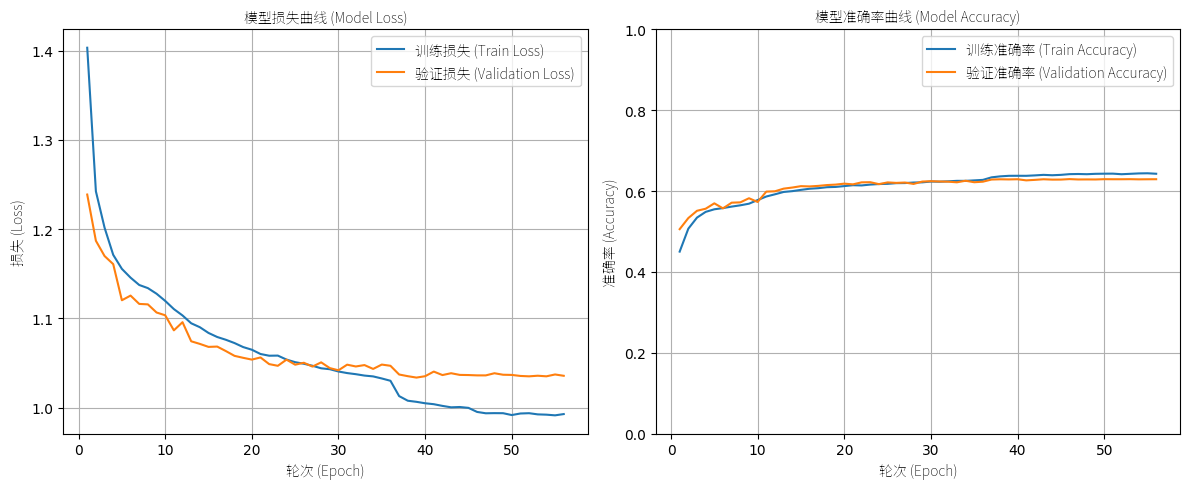

In [8]:
# ## 8. 绘制训练过程中的损失和准确率曲线
# 使用 matplotlib 和 plotting_utils 绘制训练曲线图。

print("--- 8. 绘制训练和验证曲线 ---")

# 确保记录了损失和准确率数据
if 'train_losses' in globals() and 'val_losses' in globals() and \
   'train_accuracies' in globals() and 'val_accuracies' in globals():

    plt.figure(figsize=(12, 5))

    # --- 绘制损失曲线 ---
    plt.subplot(1, 2, 1)
    # 实际训练的轮数可能因早停而小于 NUM_EPOCHS，使用记录的列表长度
    epochs_ran = range(1, len(train_losses) + 1)
    plt.plot(epochs_ran, train_losses, label='训练损失 (Train Loss)')
    plt.plot(epochs_ran, val_losses, label='验证损失 (Validation Loss)')
    # 加载字体属性用于标题和标签
    font_prop = plotting_utils._load_font_properties(FONT_FILENAME, FONT_SUBDIR)
    plt.title('模型损失曲线 (Model Loss)', fontproperties=font_prop)
    plt.xlabel('轮次 (Epoch)', fontproperties=font_prop)
    plt.ylabel('损失 (Loss)', fontproperties=font_prop)
    plt.legend(prop=font_prop)
    plt.grid(True)

    # --- 绘制准确率曲线 ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs_ran, train_accuracies, label='训练准确率 (Train Accuracy)')
    plt.plot(epochs_ran, val_accuracies, label='验证准确率 (Validation Accuracy)')
    plt.title('模型准确率曲线 (Model Accuracy)', fontproperties=font_prop)
    plt.xlabel('轮次 (Epoch)', fontproperties=font_prop)
    plt.ylabel('准确率 (Accuracy)', fontproperties=font_prop)
    plt.legend(prop=font_prop)
    plt.grid(True)
    plt.ylim(0, 1) # 设置 Y 轴范围为 0 到 1

    plt.tight_layout() # 调整子图布局
    plt.show()
else:
    print("错误: 缺少训练/验证损失或准确率数据，无法绘制曲线图。")

In [9]:
# ## 9. 加载最佳模型并在测试集上评估 (使用 Utils)
# 加载训练过程中保存的最佳模型，并在测试集上进行预测。

print("--- 9. 加载最佳模型并在测试集上进行预测 ---")

# --- 确保测试数据和加载器存在 ---
# （如果前面的 cell 可能删除了变量，重新加载/创建）
try:
    if 'X_test_norm' not in globals() or 'y_test_num' not in globals():
        print("重新加载测试数据...")
        X_test_norm = np.load(os.path.join(PROCESSED_DATA_DIR_DL_NORM, 'X_test_norm.npy'))
        y_test_num = np.load(os.path.join(PROCESSED_DATA_DIR_DL_NORM, 'y_test_num.npy'))
    if 'snr_test' not in globals():
        snr_test = np.load(os.path.join(PROCESSED_DATA_DIR_DL_NORM, 'snr_test.npy'))

    if 'test_loader' not in globals() or not isinstance(test_loader.dataset, SignalDataset) or len(test_loader.dataset) != len(y_test_num):
        print("创建测试集 Dataset 和 DataLoader...")
        test_dataset = SignalDataset(X_test_norm, y_test_num, augment=False)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                                 pin_memory=(device.type == 'cuda'), num_workers=0)

except NameError as e:
    print(f"错误：无法准备测试数据或DataLoader，缺少变量: {e}")
    raise e
except FileNotFoundError as e:
    print(f"错误：加载测试数据文件失败: {e}")
    raise e

# --- 加载最佳模型权重 ---
print(f"从 {BEST_MODEL_PATH} 加载最佳模型...")
# 确保模型实例存在并与保存的结构一致
if 'model' not in globals() or not isinstance(model, CNN_LSTM_Model):
    model = CNN_LSTM_Model(num_classes=num_classes).to(device)
    print("注意：模型实例已重新创建。")
elif next(model.parameters()).device != device: # 确保模型在正确的设备上
    model.to(device)
    print(f"注意: 模型已移至设备 {device}")

try:
    model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
    print("最佳模型权重加载成功。")
except FileNotFoundError:
    print(f"错误: 找不到模型文件 {BEST_MODEL_PATH}。请确保路径正确且模型已训练保存。")
    raise FileNotFoundError
except Exception as e:
    print(f"加载模型权重时发生错误: {e}")
    raise e

# --- 在测试集上进行预测 ---
model.eval() # 设置为评估模式
all_preds_np = []
all_labels_np = [] # 从 loader 中获取真实标签以验证

print("在测试集上进行预测...")
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        # outputs 形状: (batch_size, num_classes)
        outputs = model(inputs)
        # predicted 形状: (batch_size,)，包含预测的类别索引
        _, predicted = torch.max(outputs.data, 1)

        all_preds_np.extend(predicted.cpu().numpy())
        all_labels_np.extend(labels.cpu().numpy()) # 收集真实标签

# 转换为 NumPy 数组
y_pred_test_np = np.array(all_preds_np)
y_true_from_loader = np.array(all_labels_np) # 从 loader 获取的真实标签

# --- 验证和确定最终真实标签 ---
if 'y_test_num' in globals():
    y_true_test_np = y_test_num # 优先使用直接加载的 y_test_num
    if len(y_true_from_loader) == len(y_test_num):
        if np.array_equal(y_true_from_loader, y_test_num):
            print("从 DataLoader 收集的真实标签与原始 y_test_num 一致。")
        else:
            print("警告: DataLoader 收集的标签与原始 y_test_num 不一致！将使用原始 y_test_num。")
    else:
         print(f"警告: DataLoader 收集的标签数量 ({len(y_true_from_loader)}) 与 y_test_num ({len(y_test_num)}) 不符。将使用原始 y_test_num。")
else:
    print("警告：原始 y_test_num 未在作用域中，将使用从 DataLoader 收集的标签。")
    y_true_test_np = y_true_from_loader

print(f"预测完成。预测形状: {y_pred_test_np.shape}, 真实标签形状: {y_true_test_np.shape}")

# --- 验证 SNR 数组 ---
if 'snr_test' in globals():
    if len(snr_test) != len(y_true_test_np):
        print(f"警告: snr_test 长度 ({len(snr_test)}) 与测试集标签长度 ({len(y_true_test_np)}) 不匹配。按 SNR 评估可能不准确。")
        # 考虑是否需要截断或填充 snr_test，或者禁用 SNR 评估
        # snr_test = snr_test[:len(y_true_test_np)] # 示例：截断（如果确定顺序一致）
else:
    print("警告: snr_test 未加载，无法按 SNR 进行评估。")

# --- 清理 GPU 缓存 ---
if device.type == 'cuda':
    torch.cuda.empty_cache()
gc.collect()

--- 9. 加载最佳模型并在测试集上进行预测 ---
从 ./models/cnn_lstm_with_utils/CNN_LSTM_best_model.pth 加载最佳模型...
注意: 模型已移至设备 cuda
最佳模型权重加载成功。
在测试集上进行预测...
从 DataLoader 收集的真实标签与原始 y_test_num 一致。
预测完成。预测形状: (44000,), 真实标签形状: (44000,)


7071

In [10]:
# ## 10. 计算整体性能指标 (调用 utils)
# 使用 evaluation_utils 计算模型在整个测试集上的准确率、分类报告和混淆矩阵。

print("--- 10. 计算整体性能指标 ---")

# 确保评估所需的变量都已定义且不为空
required_vars_metrics = ['y_true_test_np', 'y_pred_test_np', 'target_names', 'num_classes']
if all(var in globals() and globals()[var] is not None and (hasattr(globals()[var], 'size') and globals()[var].size > 0 or isinstance(globals()[var], list) and len(globals()[var]) > 0 or isinstance(globals()[var], dict) and globals()[var]) for var in required_vars_metrics[:-1]) and 'num_classes' in globals() and num_classes > 0:

    # labels 参数用于指定混淆矩阵和报告的类别顺序
    labels_for_cm = np.arange(num_classes)

    # 调用工具函数计算指标 (函数内部会打印报告和矩阵)
    overall_accuracy, classification_rep, conf_matrix_overall_np = \
        evaluation_utils.calculate_metrics(
            y_true_np=y_true_test_np,
            y_pred_np=y_pred_test_np,
            target_names=target_names, # 传递类别名称列表
            labels=labels_for_cm
        )
    # 在这里可以访问返回的变量，例如打印整体准确率
    print(f"\n调用函数返回的整体准确率 (Overall Accuracy): {overall_accuracy:.4f}")

else:
    print("错误: 无法计算整体性能指标，缺少必要的变量 (y_true_test_np, y_pred_test_np, target_names, num_classes) 或变量为空。")
    # 设置默认值或标记为无效
    overall_accuracy = None
    classification_rep = "错误：缺少数据"
    conf_matrix_overall_np = None

--- 10. 计算整体性能指标 ---

计算整体性能指标...
整体准确率 (Overall Accuracy): 0.6338

分类报告 (Classification Report):

              precision    recall  f1-score   support

        8PSK     0.8003    0.5580    0.6575      4000
      AM-DSB     0.5660    0.7097    0.6298      4000
      AM-SSB     0.2760    0.9180    0.4244      4000
        BPSK     0.8576    0.6292    0.7259      4000
       CPFSK     0.8440    0.6345    0.7244      4000
        GFSK     0.8459    0.6683    0.7466      4000
        PAM4     0.9039    0.7173    0.7998      4000
       QAM16     0.7981    0.5988    0.6842      4000
       QAM64     0.8174    0.6815    0.7433      4000
        QPSK     0.8159    0.5785    0.6770      4000
        WBFM     0.7717    0.2780    0.4087      4000

    accuracy                         0.6338     44000
   macro avg     0.7542    0.6338    0.6565     44000
weighted avg     0.7542    0.6338    0.6565     44000


计算整体混淆矩阵 (使用 scikit-learn)...

整体混淆矩阵 (NumPy 数组):

[[2232   43 1176   51   96   47   30

In [11]:
# ## 11. 按 SNR 计算性能指标 (调用 utils)
# 使用 evaluation_utils 计算模型在每个 SNR 值下的准确率和混淆矩阵。

print("--- 11. 按 SNR 计算性能指标 ---")

# 确保评估所需的变量都已定义且不为空，并且长度匹配
required_vars_snr = ['y_true_test_np', 'y_pred_test_np', 'snr_test', 'labels_for_cm']
if all(var in globals() and globals()[var] is not None and (hasattr(globals()[var], 'size') and globals()[var].size > 0 or isinstance(globals()[var], list) and len(globals()[var]) > 0 or isinstance(globals()[var], dict) and globals()[var]) for var in required_vars_snr):

    if len(y_true_test_np) == len(snr_test): # 最终确认长度匹配
        # 调用工具函数计算 SNR 相关指标 (函数内部会打印详细信息)
        snr_accuracy_dict, snr_conf_matrix_np_dict = \
            evaluation_utils.calculate_snr_metrics(
                y_true_np=y_true_test_np,
                y_pred_np=y_pred_test_np,
                snr_np=snr_test,
                labels=labels_for_cm # 传递类别标签顺序
            )
        # snr_accuracy_dict 包含 {snr: accuracy}
        # snr_conf_matrix_np_dict 包含 {snr: confusion_matrix_np}
        print(f"\n调用函数返回的 SNR 准确率字典 (snr_accuracy_dict): {snr_accuracy_dict}")
        # print(f"\nSNR 混淆矩阵字典 (snr_conf_matrix_np_dict keys): {list(snr_conf_matrix_np_dict.keys())}") # 打印键以确认

    else:
        print("错误: y_true_test_np 和 snr_test 长度不匹配，无法按 SNR 计算指标。")
        snr_accuracy_dict = {}
        snr_conf_matrix_np_dict = {}
else:
    print("错误: 无法按 SNR 计算性能指标，缺少必要的变量 (y_true_test_np, y_pred_test_np, snr_test, labels_for_cm) 或变量为空。")
    snr_accuracy_dict = {}
    snr_conf_matrix_np_dict = {}

--- 11. 按 SNR 计算性能指标 ---

按 SNR 计算性能指标...
测试集中的 SNR 值: [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]
SNR = -20 dB: Accuracy = 0.1073, Samples = 2191
SNR = -18 dB: Accuracy = 0.0994, Samples = 2213
SNR = -16 dB: Accuracy = 0.1081, Samples = 2210
SNR = -14 dB: Accuracy = 0.1282, Samples = 2199
SNR = -12 dB: Accuracy = 0.1661, Samples = 2173
SNR = -10 dB: Accuracy = 0.2571, Samples = 2139
SNR =  -8 dB: Accuracy = 0.4163, Samples = 2186
SNR =  -6 dB: Accuracy = 0.5899, Samples = 2207
SNR =  -4 dB: Accuracy = 0.7123, Samples = 2228
SNR =  -2 dB: Accuracy = 0.8275, Samples = 2215
SNR =   0 dB: Accuracy = 0.8939, Samples = 2206
SNR =   2 dB: Accuracy = 0.9241, Samples = 2187
SNR =   4 dB: Accuracy = 0.9233, Samples = 2255
SNR =   6 dB: Accuracy = 0.9239, Samples = 2235
SNR =   8 dB: Accuracy = 0.9265, Samples = 2217
SNR =  10 dB: Accuracy = 0.9308, Samples = 2210
SNR =  12 dB: Accuracy = 0.9315, Samples = 2232
SNR =  14 dB: Accuracy = 0.9279, Samples = 2191

--- 12. 绘制整体混淆矩阵 ---

绘制整体混淆矩阵...
绘图：成功加载字体属性: Noto Sans SC (来自 c:\radioml_project\RadioML2016.10a_CNN_LSTM\fonts\NotoSansSC-VariableFont_wght.ttf)


<Figure size 1000x800 with 0 Axes>

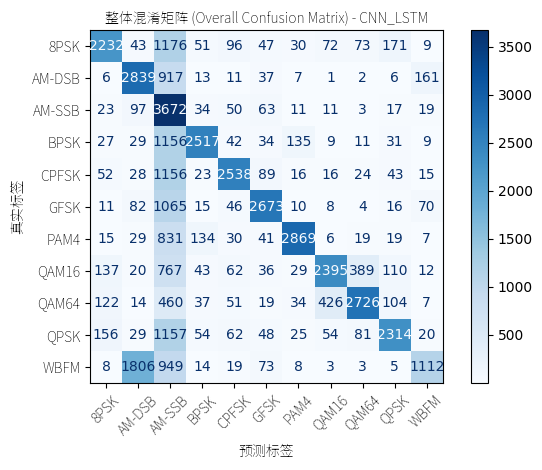

In [12]:
# ## 12. 绘制整体混淆矩阵 (调用 utils)
# 使用 plotting_utils 可视化整个测试集的混淆矩阵。

print("--- 12. 绘制整体混淆矩阵 ---")

# 确保绘图所需的变量已定义且不为空
required_vars_plot_cm = ['conf_matrix_overall_np', 'target_names', 'MODEL_NAME', 'FONT_FILENAME', 'FONT_SUBDIR']
if all(var in globals() and globals()[var] is not None for var in required_vars_plot_cm):

    plotting_utils.plot_overall_cm(
        cm_np=conf_matrix_overall_np,
        display_labels=target_names, # 使用之前确定的类别名称列表
        model_name=MODEL_NAME,       # 用于图表标题
        font_filename=FONT_FILENAME, # 传递字体信息
        font_subdir=FONT_SUBDIR
    )
    plt.show() # 确保显示图像
else:
    print("错误: 无法绘制整体混淆矩阵，缺少必要的变量 (conf_matrix_overall_np, target_names, etc.) 或混淆矩阵为空。")

--- 13. 绘制每个 SNR 下的混淆矩阵 ---

绘制不同 SNR 下的混淆矩阵...
绘图：成功加载字体属性: Noto Sans SC (来自 c:\radioml_project\RadioML2016.10a_CNN_LSTM\fonts\NotoSansSC-VariableFont_wght.ttf)
绘制包含所有 SNR 的网格混淆矩阵图...


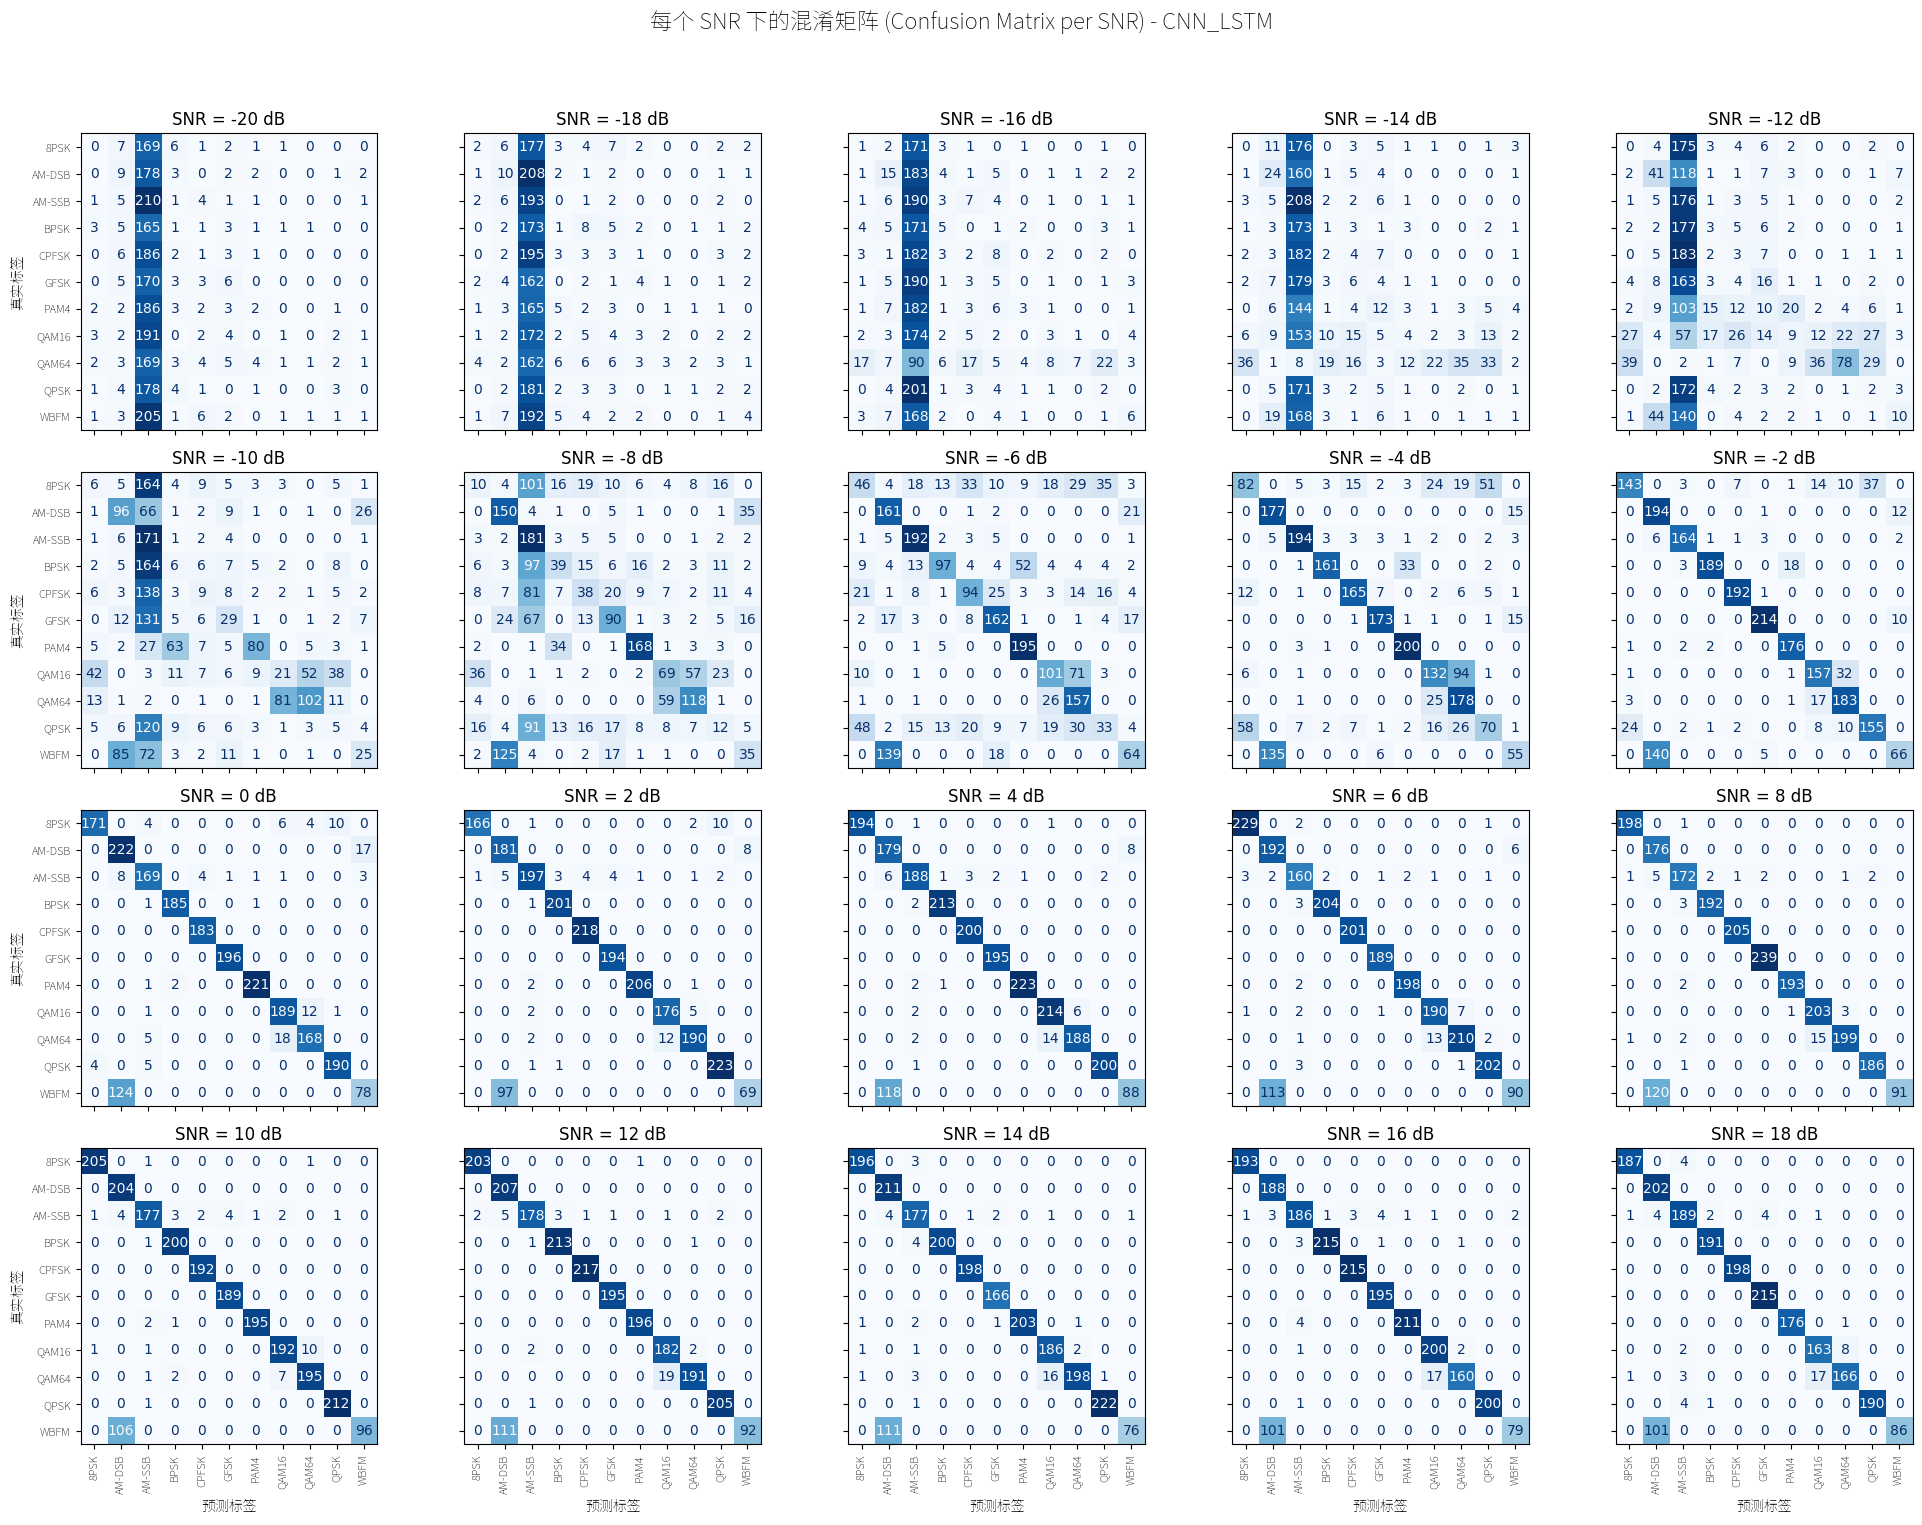

网格混淆矩阵图绘制完成。

绘制/保存每个 SNR 的单独混淆矩阵图...
单独图像将保存到 './models/cnn_lstm_with_utils/CNN_LSTM_snr_cm_plots' 目录。
已保存: ./models/cnn_lstm_with_utils/CNN_LSTM_snr_cm_plots\cm_CNN_LSTM_snr_neg20dB.png
已保存: ./models/cnn_lstm_with_utils/CNN_LSTM_snr_cm_plots\cm_CNN_LSTM_snr_neg18dB.png
已保存: ./models/cnn_lstm_with_utils/CNN_LSTM_snr_cm_plots\cm_CNN_LSTM_snr_neg16dB.png
已保存: ./models/cnn_lstm_with_utils/CNN_LSTM_snr_cm_plots\cm_CNN_LSTM_snr_neg14dB.png
已保存: ./models/cnn_lstm_with_utils/CNN_LSTM_snr_cm_plots\cm_CNN_LSTM_snr_neg12dB.png
已保存: ./models/cnn_lstm_with_utils/CNN_LSTM_snr_cm_plots\cm_CNN_LSTM_snr_neg10dB.png
已保存: ./models/cnn_lstm_with_utils/CNN_LSTM_snr_cm_plots\cm_CNN_LSTM_snr_neg8dB.png
已保存: ./models/cnn_lstm_with_utils/CNN_LSTM_snr_cm_plots\cm_CNN_LSTM_snr_neg6dB.png
已保存: ./models/cnn_lstm_with_utils/CNN_LSTM_snr_cm_plots\cm_CNN_LSTM_snr_neg4dB.png
已保存: ./models/cnn_lstm_with_utils/CNN_LSTM_snr_cm_plots\cm_CNN_LSTM_snr_neg2dB.png
已保存: ./models/cnn_lstm_with_utils/CNN_LSTM_snr_cm_plots\cm_C

In [13]:
# ## 13. 绘制每个 SNR 下的混淆矩阵 (调用 utils)
# 使用 plotting_utils 可视化每个 SNR 值对应的混淆矩阵（网格图和/或单独图）。

print("--- 13. 绘制每个 SNR 下的混淆矩阵 ---")

# 确保绘图所需的变量已定义且不为空
required_vars_plot_snr_cm = ['snr_conf_matrix_np_dict', 'target_names', 'MODEL_NAME', 'FONT_FILENAME', 'FONT_SUBDIR']
if all(var in globals() and globals()[var] for var in required_vars_plot_snr_cm):

    # 定义保存单独混淆矩阵图像的目录
    individual_fig_dir = os.path.join(MODEL_OUTPUT_DIR, f"{MODEL_NAME}_snr_cm_plots")

    plotting_utils.plot_snr_cms(
        snr_cms_dict_np=snr_conf_matrix_np_dict, # 包含 {snr: cm_np} 的字典
        display_labels=target_names,
        model_name=MODEL_NAME,
        font_filename=FONT_FILENAME,
        font_subdir=FONT_SUBDIR,
        save_individual_figs=True, # 设置为 True 以保存每个 SNR 的图像
        individual_fig_dir=individual_fig_dir # 指定保存目录
    )
    plt.show() # 显示网格图（如果生成了）
else:
    print("错误: 无法绘制每个 SNR 下的混淆矩阵，缺少必要的变量或 SNR 混淆矩阵数据为空。")

--- 14. 绘制 Accuracy vs. SNR 曲线 ---

绘制 Accuracy vs. SNR 曲线...
绘图：成功加载字体属性: Noto Sans SC (来自 c:\radioml_project\RadioML2016.10a_CNN_LSTM\fonts\NotoSansSC-VariableFont_wght.ttf)


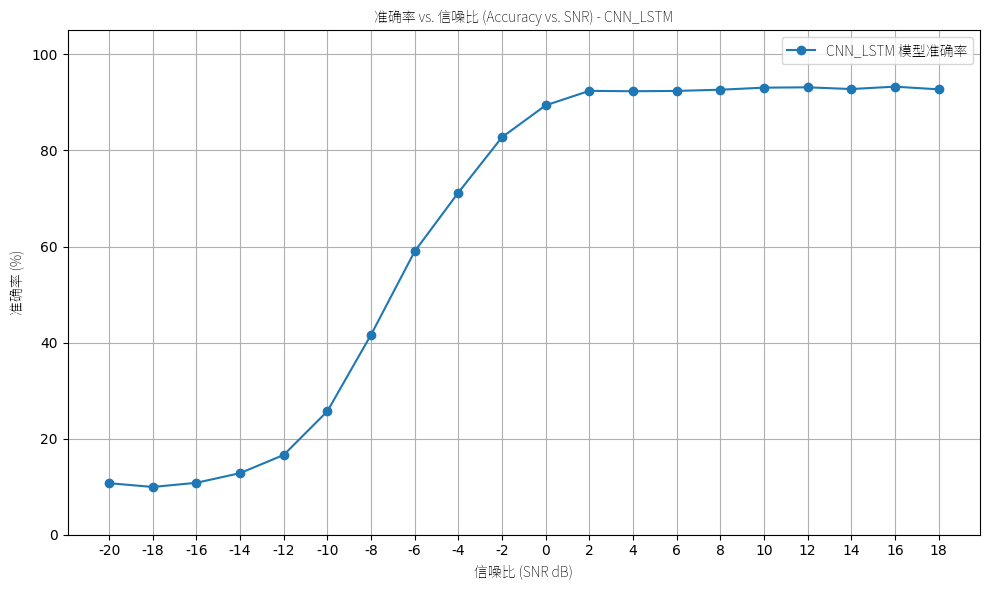

In [14]:
# ## 14. 绘制 Accuracy vs. SNR 曲线 (调用 utils)
# 使用 plotting_utils 可视化模型准确率随 SNR 变化的曲线。

print("--- 14. 绘制 Accuracy vs. SNR 曲线 ---")

# 确保绘图所需的变量已定义且不为空
required_vars_plot_acc_snr = ['snr_accuracy_dict', 'MODEL_NAME', 'FONT_FILENAME', 'FONT_SUBDIR']
if all(var in globals() and globals()[var] for var in required_vars_plot_acc_snr):

    plotting_utils.plot_acc_vs_snr(
        snr_acc_dict=snr_accuracy_dict, # 包含 {snr: accuracy} 的字典
        model_name=MODEL_NAME,
        font_filename=FONT_FILENAME,
        font_subdir=FONT_SUBDIR
    )
    plt.show() # 确保显示图像
else:
    print("错误: 无法绘制 Accuracy vs. SNR 曲线，缺少必要的变量或 SNR 准确率数据为空。")

In [15]:
# ## 15. 清理与总结

print("--- 15. 清理与总结 ---")

# 打印最终的总结信息
print(f"CNN-LSTM 模型 ({MODEL_NAME}) 训练与评估完成。")
if 'BEST_MODEL_PATH' in globals() and os.path.exists(BEST_MODEL_PATH):
    print(f"最佳模型已保存至: {BEST_MODEL_PATH}")
if 'best_val_accuracy' in globals():
    # best_val_accuracy 是训练期间验证集上的最高准确率
    print(f"训练期间达到的最佳验证准确率: {best_val_accuracy:.4f}")
if 'overall_accuracy' in globals() and overall_accuracy is not None:
    # overall_accuracy 是最佳模型在测试集上的最终准确率
    print(f"测试集上的整体准确率: {overall_accuracy:.4f}")

# 可选：进一步的内存清理
# del model, train_loader, val_loader, test_loader
# if device.type == 'cuda':
#     torch.cuda.empty_cache()
# gc.collect()

print("Notebook 执行完毕。")

--- 15. 清理与总结 ---
CNN-LSTM 模型 (CNN_LSTM) 训练与评估完成。
最佳模型已保存至: ./models/cnn_lstm_with_utils/CNN_LSTM_best_model.pth
训练期间达到的最佳验证准确率: 0.6297
测试集上的整体准确率: 0.6338
Notebook 执行完毕。
